In [1]:

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
)
import joblib


RANDOM_STATE = 42


In [2]:


df = pd.read_csv("mushroom.csv")


unnamed_cols = [c for c in df.columns if "Unnamed" in c]
if unnamed_cols:
    df.drop(columns=unnamed_cols, inplace=True)


print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample rows:")
display(df.head())

if 'class' in df.columns:
    print("\nDetected target column: 'class'")
elif 'target' in df.columns:
    print("\nDetected target column: 'target'")
else:
    
    two_val_cols = [c for c in df.columns if df[c].nunique() == 2]
    print("\nColumns with two unique values (possible target candidates):", two_val_cols)

# replace '?' with NaN (common in mushroom dataset)
df.replace('?', np.nan, inplace=True)

print("\nMissing value counts:")
display(df.isnull().sum())


Shape: (2000, 25)

Columns: ['cap_shape', 'cap_surface', 'cap_color', 'bruises', 'odor', 'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color', 'stalk_shape', 'stalk_root', 'stalk_surface_above_ring', 'stalk_surface_below_ring', 'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type', 'veil_color', 'ring_number', 'ring_type', 'spore_print_color', 'population', 'habitat', 'class', 'stalk_height', 'cap_diameter']

Sample rows:


,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,...,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat,class,stalk_height,cap_diameter
0,sunken,scaly,white,no,anise,descending,distant,broad,pink,tapering,...,partial,brown,two,sheathing,chocolate,clustered,waste,poisonous,14.276173,5.054983
1,sunken,fibrous,red,no,anise,notched,crowded,narrow,chocolate,enlarging,...,universal,brown,two,sheathing,brown,numerous,waste,edible,3.952715,19.068319
2,flat,grooves,purple,yes,foul,descending,crowded,broad,purple,tapering,...,universal,yellow,two,sheathing,purple,abundant,waste,poisonous,9.054265,7.205884
3,bell,scaly,pink,yes,fishy,notched,close,broad,orange,enlarging,...,partial,yellow,two,cobwebby,green,clustered,grasses,poisonous,5.226499,20.932692
4,flat,smooth,yellow,yes,musty,free,crowded,narrow,orange,enlarging,...,universal,white,none,none,yellow,clustered,urban,poisonous,14.037532,12.545245



Detected target column: 'class'

Missing value counts:


cap_shape                   0
cap_surface                 0
cap_color                   0
bruises                     0
odor                        0
gill_attachment             0
gill_spacing                0
gill_size                   0
gill_color                  0
stalk_shape                 0
stalk_root                  0
stalk_surface_above_ring    0
stalk_surface_below_ring    0
stalk_color_above_ring      0
stalk_color_below_ring      0
veil_type                   0
veil_color                  0
ring_number                 0
ring_type                   0
spore_print_color           0
population                  0
habitat                     0
class                       0
stalk_height                0
cap_diameter                0
dtype: int64

In [3]:

if 'class' in df.columns:
    target_col = 'class'
elif 'target' in df.columns:
    target_col = 'target'
else:
    two_val_cols = [c for c in df.columns if df[c].nunique() == 2]
    if len(two_val_cols) == 1:
        target_col = two_val_cols[0]
    else:
        raise ValueError(
            "Couldn't auto-detect a single binary target column. "
            "Set target_col manually to the correct column name."
        )

print("Using target column:", target_col)

X = df.drop(columns=[target_col])
y = df[target_col].copy()

# encode target to 0/1 (LabelEncoder)
le = LabelEncoder()
y_enc = le.fit_transform(y)

print("Target classes (label encoder):", dict(enumerate(le.classes_)))


Using target column: class
Target classes (label encoder): {0: 'edible', 1: 'poisonous'}


In [4]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=RANDOM_STATE, stratify=y_enc
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (1600, 24) Test shape: (400, 24)


In [6]:
import sklearn
from packaging import version

if version.parse(sklearn.__version__) >= version.parse("1.2"):
    onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
else:
    onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', onehot),
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True, random_state=RANDOM_STATE))
])


In [7]:
# Step 5: hyperparameter grid and GridSearchCV
param_grid = [
    {'svc__kernel': ['linear'], 'svc__C': [0.1, 1.0, 10.0]},
    {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1.0, 10.0], 'svc__gamma': ['scale', 'auto']},
    {'svc__kernel': ['poly'], 'svc__C': [1.0, 5.0], 'svc__degree': [2, 3]}
]

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1_macro',   # good for balanced measure across classes
    cv=5,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Fit (this may take a few minutes depending on dataset size & grid)
grid.fit(X_train, y_train)


Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='most_frequent')),
                                       ('onehot',
                                        OneHotEncoder(handle_unknown='ignore',
                                                      sparse_output=False)),
                                       ('scaler', StandardScaler()),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid=[{'svc__C': [0.1, 1.0, 10.0],
                          'svc__kernel': ['linear']},
                         {'svc__C': [0.1, 1.0, 10.0],
                          'svc__gamma': ['scale', 'auto'],
                          'svc__kernel': ['rbf']},
                         {'svc__C': [1.0, 5.0], 'svc__degree': [2, 3],
                          'svc__kernel': ['poly']}],
             return_train_score=True, scoring='f1_macro', verbose=2)

In [8]:
print("Best params:", grid.best_params_)
print("Best CV f1_macro:", grid.best_score_)


Best params: {'svc__C': 0.1, 'svc__kernel': 'linear'}
Best CV f1_macro: 0.8010526004473911


In [9]:

cvres = pd.DataFrame(grid.cv_results_)[
    ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
].sort_values('rank_test_score').reset_index(drop=True)
display(cvres.head(8))


,params,mean_test_score,std_test_score,rank_test_score
0,"{'svc__C': 0.1, 'svc__kernel': 'linear'}",0.801053,0.015813,1
1,"{'svc__C': 1.0, 'svc__kernel': 'linear'}",0.801053,0.015813,1
2,"{'svc__C': 10.0, 'svc__kernel': 'linear'}",0.801053,0.015813,1
3,"{'svc__C': 1.0, 'svc__gamma': 'scale', 'svc__k...",0.801053,0.015813,1
4,"{'svc__C': 10.0, 'svc__gamma': 'scale', 'svc__...",0.801053,0.015813,1
5,"{'svc__C': 1.0, 'svc__gamma': 'auto', 'svc__ke...",0.801053,0.015813,1
6,"{'svc__C': 1.0, 'svc__degree': 2, 'svc__kernel...",0.801053,0.015813,1
7,"{'svc__C': 10.0, 'svc__gamma': 'auto', 'svc__k...",0.801053,0.015813,1


Test accuracy: 0.8575

Classification report:
              precision    recall  f1-score   support

      edible       1.00      0.53      0.69       120
   poisonous       0.83      1.00      0.91       280

    accuracy                           0.86       400
   macro avg       0.92      0.76      0.80       400
weighted avg       0.88      0.86      0.84       400



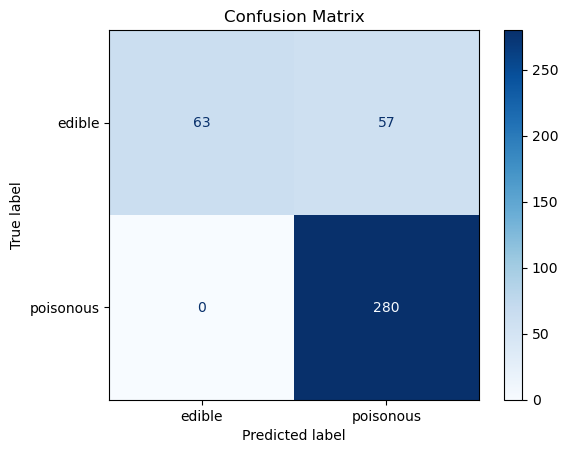

In [10]:

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test accuracy:", acc)
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Test ROC AUC: 0.9402083333333333


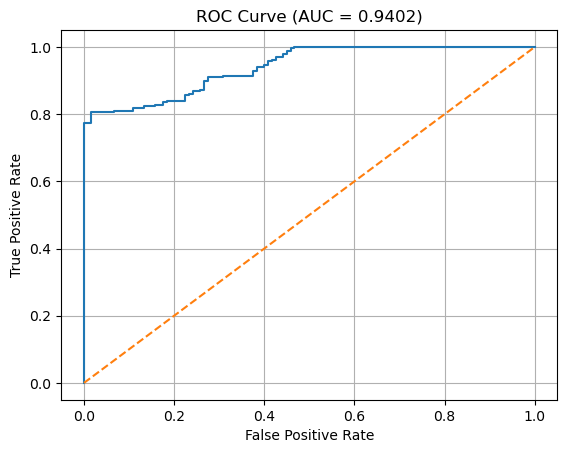

In [11]:

if len(le.classes_) == 2:
    y_proba = best_model.predict_proba(X_test)[:, 1]   # probability of positive class
    auc = roc_auc_score(y_test, y_proba)
    print("Test ROC AUC:", auc)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr)            # no custom colors per rules
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (AUC = {:.4f})".format(auc))
    plt.grid(True)
    plt.show()
else:
    print("ROC/AUC skipped: target has more than two classes.")


In [12]:
out_path = "svm_mushroom_pipeline.joblib"
joblib.dump(best_model, out_path)
print("Saved pipeline to:", out_path)

Saved pipeline to: svm_mushroom_pipeline.joblib
